In [40]:
import cv2
import numpy as np
import time
from scipy.ndimage import label
from matplotlib import pyplot as plt

from utils import method2 as M2
from utils import commonFunctions as CF


plt.rcParams["figure.figsize"] = (7,7)

In [41]:
def computeMexHatKernel(radius = 5):
    sz = 2 * radius + 1
    #  this formula recreates the kernel from the ImageJ Mexican hat plugin, which drops in some magic numbers without explanation, and
    #  due to a coding mistake only adds 1.0/6.0 in the 3rd factor, but not in
    #  the second. the intended formula is probably
    #  sigma2 = 2*(r/3.0+1.0/6.0)*(r/3.0 +1.0/6.0);

    mexHatKernel = np.zeros((sz, sz))
    sigma2 = 2 * (radius / 3.0 + 1.0 / 6.0) * (radius / 3.0 + 1.0 / 6.0)
    PIs = 0.024444693984887; #4.0/sqrt(pi()*sigma2)/sigma2/sigma2;
    sumOfKernel = 0
    x2 = 0
    idx_x = 0
    idx_y = 0
    for u in range(-radius, radius): #u = -r:1:r
    
        for w in range(-radius, radius): #for w = -r:1:r
        
            x2 = u * u + w * w
            idx_x = u + radius
            idx_y = w + radius
            mexHatKernel[idx_x, idx_y] = -((x2 - sigma2) * np.exp(-x2 / sigma2) * PIs)
            #                  kernel(idx+1) = single((x2 -sigma2)*exp(-x2/sigma2))
            #             /System.out.print(kernel(c) +" ");
            sumOfKernel = sumOfKernel + mexHatKernel[idx_x, idx_y]
        
    

    sumOfKernel = abs(sumOfKernel)
    if (sumOfKernel < 1e-5):
        sumOfKernel = 1

    if (sumOfKernel != 1):
        mexHatKernel = mexHatKernel / sumOfKernel

    return mexHatKernel


In [42]:
def average_cores(core_arr, core_arr_bool, idx, im, core_x, core_y, num_cores):
    # Copy core values from image to core array. The array is initialised to 0 beforehand.
    core_arr_vals[idx,:] = im[core_arr_y[idx,:],core_x[idx,:]]

    # Calculate mean value per core. The boolean array within "where" was preset to be True
    # for array locations where core values are expected and False for array locations where no
    # no value is expected. With optics used, maximum 70-80 pixels per core is expected.
    core_arr_mean = np.mean(core_arr,axis=1,where=core_arr_bool)

    # Remap back to image the means of whole core back into image. For some reason, I could not vectorise 
    # code below, hence the for loop. Trying to figure out the limitations of vectorisation.
    im[core_y[idx,:],core_x[idx,:]] = core_arr_mean[idx, None]

In [43]:
#Apply fibre mask
lightfield = cv2.imread('./test images/_Dominic test images/Calibration Data/Exposure_250ms/2018-02-27_14-11-42_Light_Background_Blue.tif',0)
im_darkfld = cv2.imread('./test images/_Dominic test images/Calibration Data/Exposure_250ms/2018-02-27_14-11-02_Background_Blue.tif',0)
#medianFiltered = lightfield - dadrk field
medianFiltered = lightfield - im_darkfld
#median blur (median filtered) with 41 pixel width
medianFiltered = cv2.medianBlur(medianFiltered, 41)
ret3,FibreMask = cv2.threshold(medianFiltered,1,255,cv2.THRESH_BINARY)
FibreMask = FibreMask/255

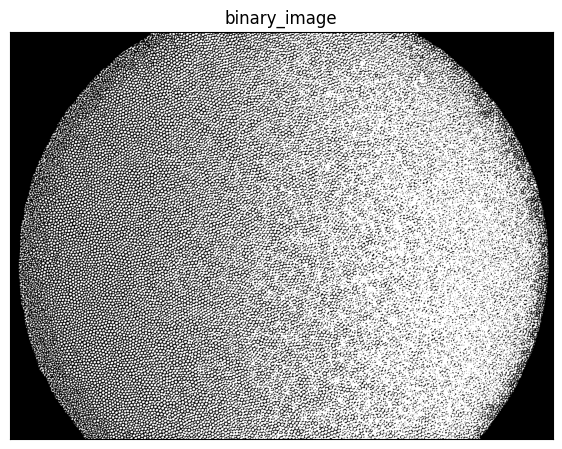

In [44]:
import math

im_darkfld = cv2.imread('./test images/_Dominic test images/Calibration Data/Exposure_25ms/2018-02-27_14-11-21_Background_Blue.tif',0).astype(np.float32)
im_ltfld = cv2.imread('./test images/_Dominic test images/Calibration Data/Exposure_25ms/2018-02-27_14-11-46_Light_Background_Blue.tif',0).astype(np.float32)   

imgHeight, imgWidth = im_ltfld.shape

#compute mexican hat kernal
radius = 5
mexHatKernel = computeMexHatKernel(radius)

#Normalise images
im_denom = cv2.subtract(im_ltfld, im_darkfld)
im_denom = im_denom.astype(np.uint8)

anchor = (-1, -1)
delta = 0
ddepth = -1

#Apply mexican hat filtering
imgMexHatFiltered = cv2.filter2D(im_denom, ddepth, mexHatKernel, anchor=anchor, delta=delta, borderType=cv2.BORDER_DEFAULT)

#Multiply Binary fibre mask to remove surrounding noise
imgMexHatFilteredMasked = imgMexHatFiltered * FibreMask

#Threshold image
ret, imgMexHatFilteredMaskedBinarized = cv2.threshold(imgMexHatFilteredMasked, 0, 255, cv2.THRESH_BINARY)
u8_imgMexHatBinarized = imgMexHatFilteredMaskedBinarized.astype(np.uint8)


ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.imshow(u8_imgMexHatBinarized,cmap='gray')
plt.title('binary_image')
plt.show()

# cv2.imshow('binary', center_binary_image)
# cv2.waitKey(0)

In [45]:
import cv2
import numpy as np
from IPython.display import Image, display
from matplotlib import pyplot as plt

# Plot the image
def imshow(img, ax=None):
    if ax is None:
        ret, encoded = cv2.imencode(".jpg", img)
        display(Image(encoded))
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.axis('off')


def non_maxima_suppression(image, dilationSize, remove_plateaus):

    mask = cv2.dilate(image, np.ones((dilationSize, dilationSize)))
    mask = cv2.compare(image, mask, cmpop=cv2.CMP_GE)

    # optionally filter out pixels that are equal to the local minimum ('plateaus')
    if (remove_plateaus):
        erodeKernal = np.ones((3, 3))

        non_plateau_mask = cv2.erode(image, erodeKernal)
        non_plateau_mask = cv2.compare(image, non_plateau_mask, cmpop=cv2.CMP_GT)
        mask = cv2.bitwise_and(mask, non_plateau_mask)


    return mask

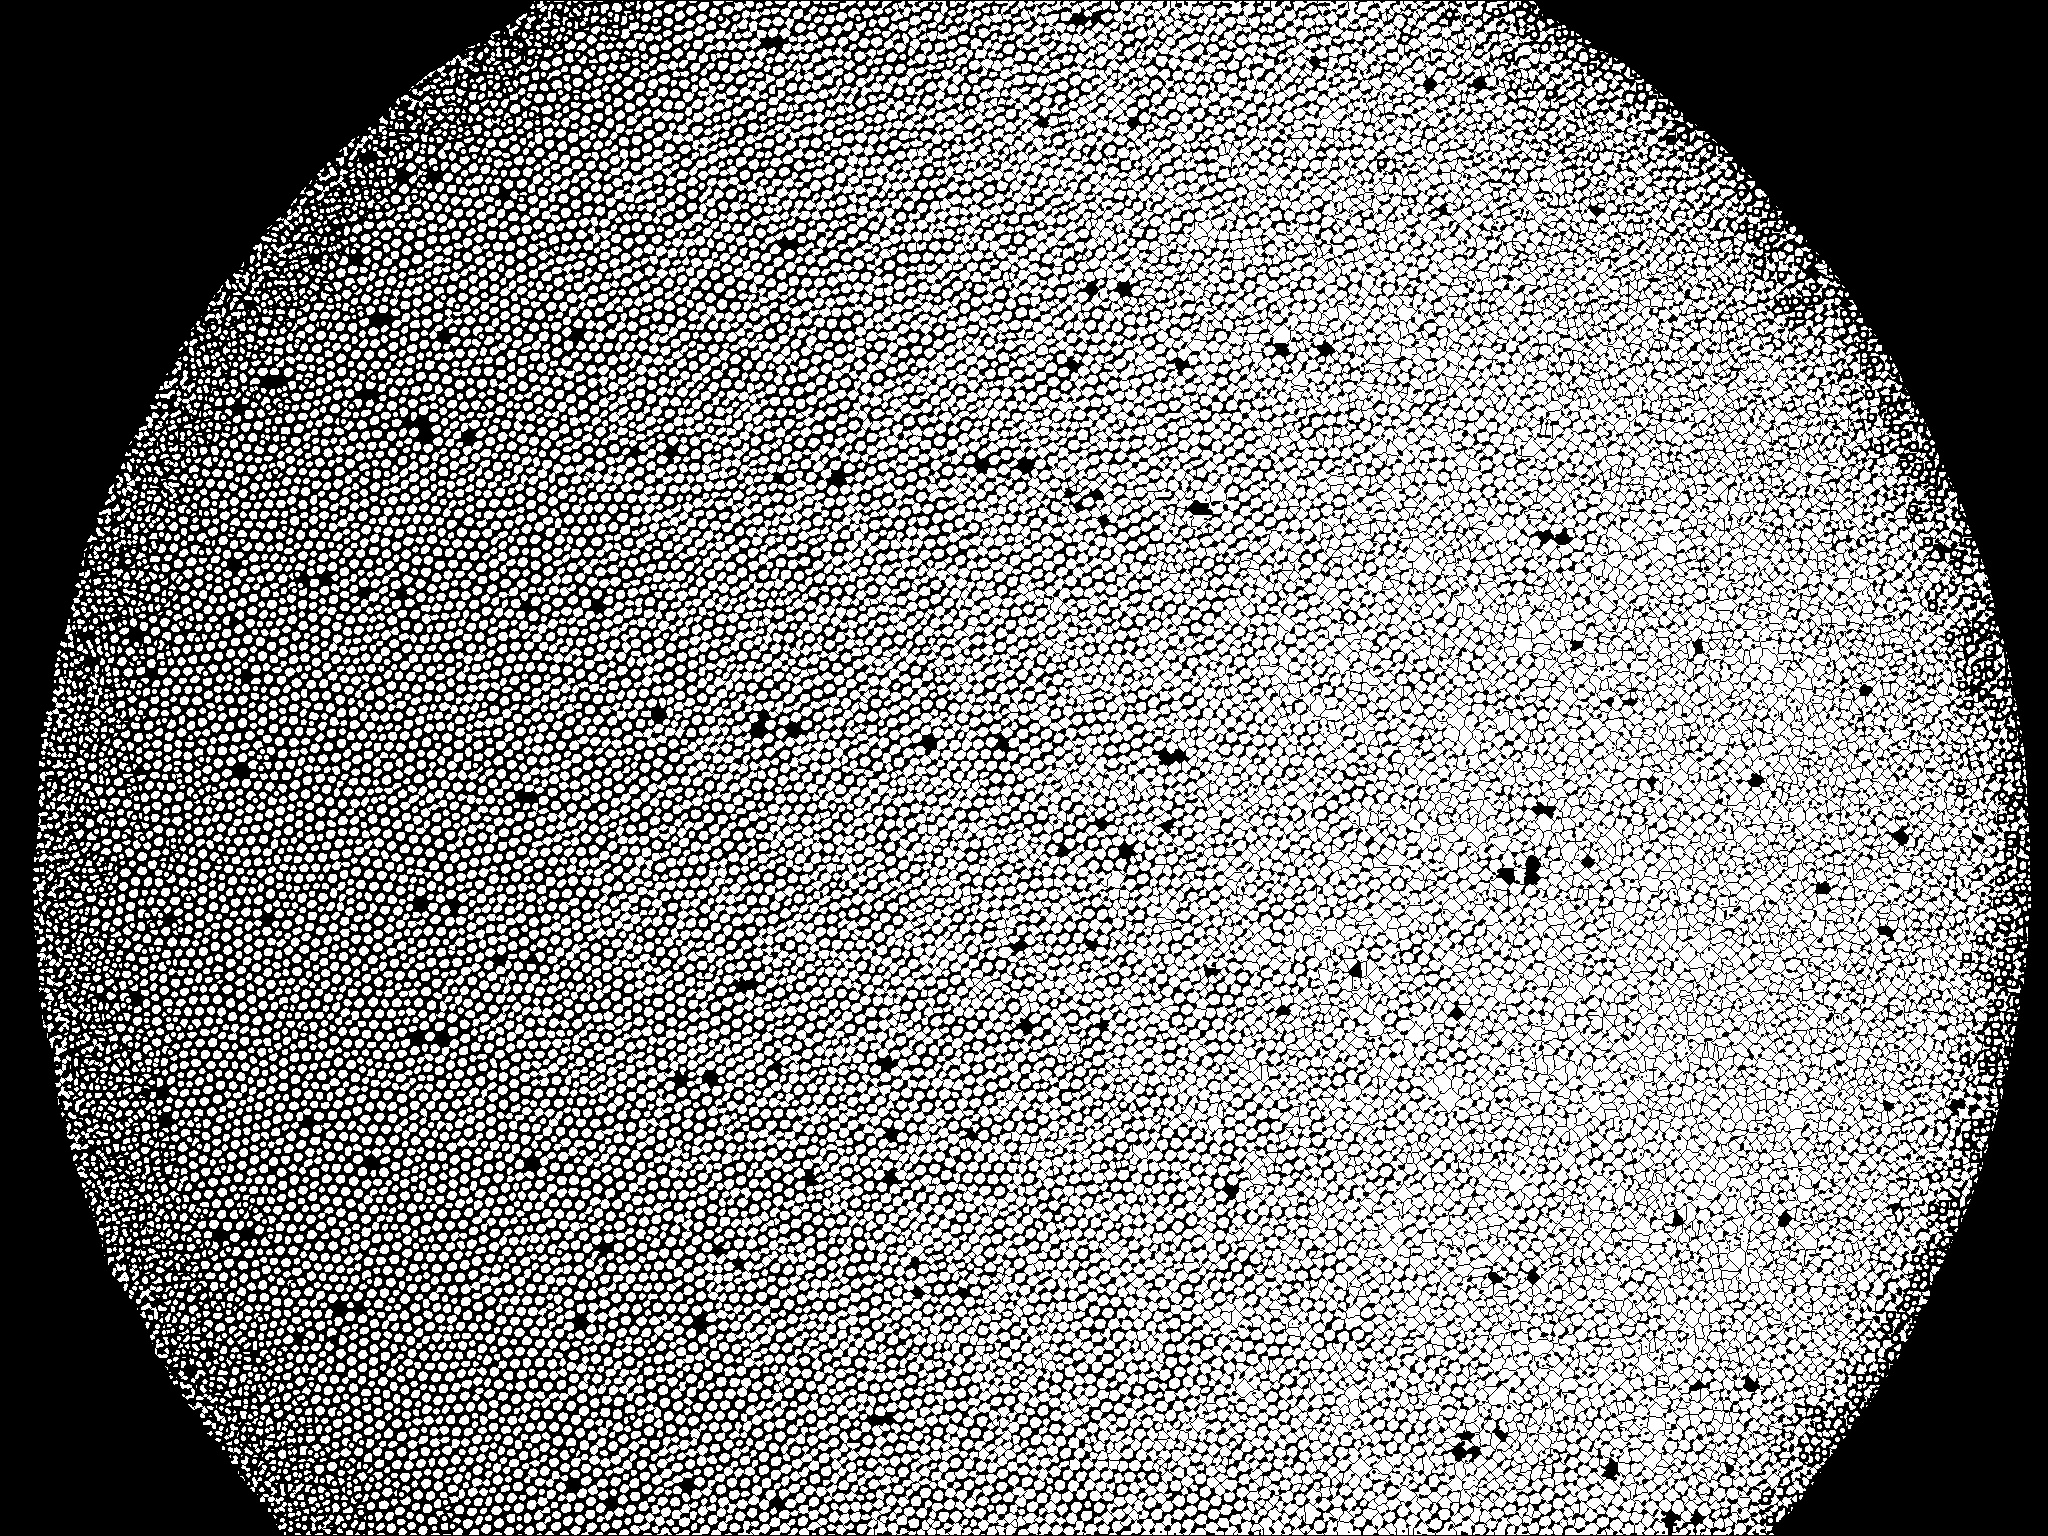

In [49]:
#Apply watershed

# Distance transform
coreMaskBinaryEDM = cv2.distanceTransform(u8_imgMexHatBinarized, cv2.DIST_L2, 5)

mask = non_maxima_suppression(coreMaskBinaryEDM, 7, True)
  
retval, labelsEDMMax = cv2.connectedComponents(mask, connectivity=8)


distLimit = 4
for posX in range(0,imgHeight-1):
    #std::cout << posX << std::endl;
    for posY in range(0,imgWidth-1):
        # get current label
        currentLabel = labelsEDMMax[posX][posY]

        if not currentLabel:
            continue; # label == 0 means background
        
        # if label isn't 0, check for other labels nearby
        # iterate through surrounding pixels within distance threshold and check if their labels are different
        for posXrel in range(posX - distLimit, posX + distLimit):
            for posYrel in range(posY - distLimit, posY + distLimit):
                if (posXrel >= 0 and posYrel >= 0 and posXrel < imgHeight and posYrel < imgWidth):
                    if (posXrel == posX and posYrel == posY):
                        continue; # no need to check itself

                    # check distance between centroids of labels
                    distance = np.sqrt(pow((posX - posXrel), 2) + pow((posY - posYrel), 2))

                    # if labels are different within distance, relabel all pixels with the same label to the current one
                    if (distance <= distLimit):
                        comparisonLabel = labelsEDMMax[posXrel, posYrel]

                        if not comparisonLabel:
                            continue; # label == 0 means background
                        if (comparisonLabel != currentLabel):
                            labelsEDMMax[labelsEDMMax == comparisonLabel] = currentLabel



u8_imgMexHatBinarizedGray = cv2.cvtColor(u8_imgMexHatBinarized, cv2.COLOR_GRAY2BGR)
labelsEDMMax = cv2.watershed(u8_imgMexHatBinarizedGray, labelsEDMMax)
labelsEDMMax = labelsEDMMax.astype(np.uint8)

u8_binaryAfterWatershed = labelsEDMMax * u8_imgMexHatBinarized
# binaryAfterWatershed = u8_binaryAfterWatershed.astype(np.float32)

ret, binaryAfterWatershedMasked = cv2.threshold(u8_binaryAfterWatershed, 1, 255, cv2.THRESH_BINARY)

imshow(binaryAfterWatershedMasked)

# imshow(binaryAfterWatershedMasked)

# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.imshow(u8_binaryAfterWatershed,cmap='gray')
# plt.title('u8_binaryAfterWatershed')
# plt.show()



In [47]:
# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.imshow(binary_image,cmap='gray')
# plt.title('binary_image')
# plt.show()

# center_binary_image = binary_image[math.floor(imgWidth/2-128):math.floor(imgWidth/2+128), math.floor(imgHeight/2-128):math.floor(imgHeight/2+128)]

# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.imshow(center_binary_image*255,cmap='gray')
# plt.title('einsum image interpolated')
# plt.show()

In [48]:
# im_darkfld = cv2.imread('./test images/Calibration Data/Exposure_25ms/backgroundMid.tif',0).astype(np.float32)
# im_ltfld = cv2.imread('./test images/Calibration Data/Exposure_25ms/lightfieldMid.tif',0).astype(np.float32)

# im_denom = cv2.subtract(im_ltfld, im_darkfld)
# im_denom = im_denom.astype(np.uint8)
# minimum_thres = 55 #38
# ret, binary_image = cv2.threshold(im_denom, minimum_thres, 255, cv2.THRESH_BINARY)

# ax = plt.gca()
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.imshow(binary_image,cmap='gray')
# plt.title('einsum image interpolated')
# plt.show()